## Pronóstico de series de tiempo de precipitación con autoencoder (CR2MET)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
import math

gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("GPUs:", gpus)

mixed_precision.set_global_policy("mixed_float16")
print("Policy:", mixed_precision.global_policy())

2025-10-15 22:28:29.253425: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 22:28:29.287693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 22:28:29.287721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 22:28:29.287753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 22:28:29.296240: I tensorflow/core/platform/cpu_feature_g

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9
Policy: <Policy "mixed_float16">


2025-10-15 22:28:31.394522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:28:31.400225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:28:31.400263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:28:31.400886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
folder = "../data/CR2MET_pr_v2.5/"
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nc")]
ds = xr.open_mfdataset(files, combine='by_coords')
ds['pr'] = ds['pr'].fillna(0)
ds

/tmp/ipykernel_128730/1078490275.py:3: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, combine='by_coords')


<xarray.Dataset> Size: 54GB
Dimensions:  (time: 15341, lat: 800, lon: 220)
Coordinates:
  * lon      (lon) float64 2kB -76.97 -76.92 -76.88 ... -66.12 -66.08 -66.03
  * lat      (lat) float64 6kB -56.98 -56.93 -56.88 ... -17.12 -17.07 -17.02
  * time     (time) datetime64[ns] 123kB 1980-01-01 1980-01-02 ... 2021-12-31
Data variables:
    pr       (time, lat, lon) float64 22GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    pr_sd    (time, lat, lon) float64 22GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
    cl_mask  (time, lat, lon) float32 11GB dask.array<chunksize=(31, 800, 220), meta=np.ndarray>
Attributes: (12/28)
    creation_date:        29-Aug-2022 18:46:14
    authors:              Boisier et al.
    obs_file:             MERGE5_QC_UCC_pr_day_1979_2021.csv
    topo_res:             005 025 05
    ls_vars_all:          pr logpr prc prmax pr2d iqu iqv tcw cape
    ls_vars_o15:          iqu iqv tcw cape
    ...                   ...
    ens_qtl_value:        0.5
    log_pr_thre:          10
    ens_force_dry:        0
    AV_obs_file:          MERGE5_QC_FI_full_pr_mon_1960_2021_ny_min_20.csv
    AV_n_modes_pca:       50
    AV_n_modes_cca:       25

In [3]:

ds = ds.sel(time=slice("1980-01-01", "2022-12-31")) # Filtra desde 2000 a 2022
# zona Maule - Ñuble
ds = ds.where((ds.lat <= -34) & (ds.lat >= -38), drop=True)
ds = ds.where((ds.lon <= -70) & (ds.lon >= -73), drop=True)
ds['pr'] = ds['pr'].where(ds['pr'] >= 0, 0) # Hace toda pr>=0

# rename Vars
ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})
ds

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 15341, latitude: 80, longitude: 60)
Coordinates:
  * longitude  (longitude) float64 480B -72.97 -72.92 -72.88 ... -70.08 -70.03
  * latitude   (latitude) float64 640B -37.98 -37.92 -37.88 ... -34.08 -34.02
  * time       (time) datetime64[ns] 123kB 1980-01-01 1980-01-02 ... 2021-12-31
Data variables:
    pr         (time, latitude, longitude) float64 589MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
    pr_sd      (time, latitude, longitude) float64 589MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
    cl_mask    (time, latitude, longitude) float32 295MB dask.array<chunksize=(31, 80, 60), meta=np.ndarray>
Attributes: (12/28)
    creation_date:        29-Aug-2022 18:46:14
    authors:              Boisier et al.
    obs_file:             MERGE5_QC_UCC_pr_day_1979_2021.csv
    topo_res:             005 025 05
    ls_vars_all:          pr logpr prc prmax pr2d iqu iqv tcw cape
    ls_vars_o15:          iqu iqv tcw cape
    ...                   ...
    ens_qtl_value:        0.5
    log_pr_thre:          10
    ens_force_dry:        0
    AV_obs_file:          MERGE5_QC_FI_full_pr_mon_1960_2021_ny_min_20.csv
    AV_n_modes_pca:       50
    AV_n_modes_cca:       25

In [4]:
# =========================
# 2) Ordena coords: lon O→E, lat S→N
# =========================
#if float(ds.longitude[0]) > float(ds.longitude[-1]):
#    ds = ds.sortby("longitude", ascending=False)
# ERA5 suele traer lat N→S; queremos S→N (ascendente)
#if float(ds.latitude[0]) > float(ds.latitude[-1]):
#    ds = ds.sortby("latitude", ascending=False)

In [5]:
# =========================
# 3) Extrae tensor base (T, H, W, C)
# =========================
pr = ds["pr"]  # mm por paso temporal
# Asegura dtype
pr = pr.astype("float32")

# Manejo de NaNs: relleno + canal máscara (opcional)
use_mask_channel = False
if pr.isnull().any():
    use_mask_channel = True
    mask = xr.where(pr.notnull(), 1.0, 0.0).astype("float32")
    pr = pr.fillna(0.0)

# A (T,H,W)
X = pr.transpose("time", "latitude", "longitude").values  # -> (T,H,W)
T_total, H, W = X.shape

# Apila canales
channels = [X[..., None]]  # C=1
if use_mask_channel:
    M = mask.transpose("time", "latitude", "longitude").values.astype("float32")
    channels.append(M[..., None])  # C+=1
X_full = np.concatenate(channels, axis=-1).astype("float32")  # (T,H,W,C)
C = X_full.shape[-1]

print("Forma maestro:", X_full.shape)  # esperado: (8401, 41, 41, C)

Forma maestro: (15341, 80, 60, 1)


In [6]:
# =========================
# 4) Splits temporales (ajusta fechas a tu rango real)
# =========================
# Usa las fechas del dataset para que no falle si no tienes todo 2000–2022
t0 = np.datetime_as_string(ds.time.values[0], unit="D")
t1 = np.datetime_as_string(ds.time.values[-1], unit="D")
print("Rango temporal:", t0, "→", t1)

Rango temporal: 1980-01-01 → 2021-12-31


In [7]:
time_train = ["2000-01-01", "2015-12-31"]
time_val = ["2016-01-01", "2018-12-31"]
time_test = ["2019-01-01",None]

time_train = ["1980-01-01", "2015-12-31"]
time_val = ["2016-01-01", "2018-12-31"]
time_test = ["2019-01-01",None]

def to_array(dsi):
    arr = dsi["pr"].transpose("time", "latitude", "longitude").astype("float32")
    if use_mask_channel:
        m = xr.where(dsi["pr"].notnull(), 1.0, 0.0).transpose("time","latitude","longitude").astype("float32")
        arr = xr.concat([arr, m], dim="channel")  # (time, lat, lon, channel) pero falta expand
        arr = arr.transpose("time","latitude","longitude","channel")
        return arr.values
    else:
        return arr.values[..., None]

Xtr = to_array(ds.sel(time=slice(time_train[0], time_train[1])))
Xva = to_array(ds.sel(time=slice(time_val[0], time_val[1])))
Xte = to_array(ds.sel(time=slice(time_test[0], time_test[1])))

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (13149, 80, 60, 1) Val: (1096, 80, 60, 1) Test: (1096, 80, 60, 1)


In [8]:
# =========================
# 5) Normalización (solo con TRAIN)
#    z-score por canal; para precip muy sesgada podrías hacer log1p antes
# =========================
# Si quieres log1p solo en canal 0 (pr), descomenta:
# Xtr[...,0] = np.log1p(Xtr[...,0])
# Xva[...,0] = np.log1p(Xva[...,0])
# Xte[...,0] = np.log1p(Xte[...,0])

# Stats por canal usando train (media/σ sobre (time, lat, lon))
mu = Xtr.reshape(-1, C).mean(axis=0)
sd = Xtr.reshape(-1, C).std(axis=0) + np.finfo(float).eps

def normalize(x, mu, sd):
    return (x - mu.reshape(1,1,1,C)) / sd.reshape(1,1,1,C)

#Xtr = normalize(Xtr, mu, sd).astype("float32")
#Xva = normalize(Xva, mu, sd).astype("float32")
#Xte = normalize(Xte, mu, sd).astype("float32")

# =========================
# 6) Ventaneo temporal (N, T, H, W, C)
# =========================
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas

"""
def make_windows(X4d, T=32, S=4):
    
    #X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)
    #Ventaneo solo en tiempo, con stride S.
    
    tlen = X4d.shape[0]
    if tlen < T:
        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)
    starts = np.arange(0, tlen - T + 1, S, dtype=int)
    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)
    for j, i in enumerate(starts):
        out[j] = X4d[i:i+T]   # (T, H, W, C)
    return out

Xtr_w = make_windows(normalize(Xtr, mu, sd), T_window, stride)
Xva_w = make_windows(normalize(Xva, mu, sd), T_window, stride)
Xte_w = make_windows(normalize(Xte, mu, sd), T_window, stride)

print("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)
# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)
"""

'\ndef make_windows(X4d, T=32, S=4):\n\n    #X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)\n    #Ventaneo solo en tiempo, con stride S.\n\n    tlen = X4d.shape[0]\n    if tlen < T:\n        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)\n    starts = np.arange(0, tlen - T + 1, S, dtype=int)\n    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)\n    for j, i in enumerate(starts):\n        out[j] = X4d[i:i+T]   # (T, H, W, C)\n    return out\n\nXtr_w = make_windows(normalize(Xtr, mu, sd), T_window, stride)\nXva_w = make_windows(normalize(Xva, mu, sd), T_window, stride)\nXte_w = make_windows(normalize(Xte, mu, sd), T_window, stride)\n\nprint("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)\n# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)\n'

In [9]:
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE


def make_start_indices(T_total, T, S):
    n = max((T_total - T) // S + 1, 0)
    return np.arange(n, dtype=np.int32) * S

def dataset_from_array(X, T=32, S=4, batch=2, shuffle=4096, prefetch=2, training=True):
    # X: (T_total, H, W, C) ya normalizado (float16 recomendado)
    X_tf = tf.convert_to_tensor(X)  # no copia grande si ya es contiguous
    starts = make_start_indices(X.shape[0], T, S)

    ds = tf.data.Dataset.from_tensor_slices(starts)
    if training:
        ds = ds.shuffle(min(len(starts), shuffle), reshuffle_each_iteration=True)

    @tf.function  # forma y grafo estables
    def _extract(i):
        w = X_tf[i:i+T]              # (T,H,W,C)
        return w, w                  # AE: input = target

    ds = ds.map(_extract, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=False).prefetch(prefetch)
    return ds

train_ds = dataset_from_array(normalize(Xtr, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)
val_ds = dataset_from_array(normalize(Xva, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)  # stride mayor en val
test_ds = dataset_from_array(normalize(Xte, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)  # stride mayor en val

2025-10-15 22:30:50.421677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:30:50.421800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:30:50.421824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:30:52.172021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-15 22:30:52.173365: I tensorflow/compile

In [10]:
"""
# =========================
# 7) tf.data Datasets
# =========================
batch_size = 2
AUTOTUNE = tf.data.AUTOTUNE

def to_ds(X):
    ds = tf.data.Dataset.from_tensor_slices((X, X))  # AE: input = target
    #ds = ds.shuffle(min(len(X), 4096), reshuffle_each_iteration=True, seed=42)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = to_ds(Xtr_w)
val_ds   = tf.data.Dataset.from_tensor_slices((Xva_w, Xva_w)).batch(batch_size).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((Xte_w, Xte_w)).batch(batch_size)
"""

'\n# =========================\n# 7) tf.data Datasets\n# =========================\nbatch_size = 2\nAUTOTUNE = tf.data.AUTOTUNE\n\ndef to_ds(X):\n    ds = tf.data.Dataset.from_tensor_slices((X, X))  # AE: input = target\n    #ds = ds.shuffle(min(len(X), 4096), reshuffle_each_iteration=True, seed=42)\n    ds = ds.batch(batch_size).prefetch(AUTOTUNE)\n    return ds\n\ntrain_ds = to_ds(Xtr_w)\nval_ds   = tf.data.Dataset.from_tensor_slices((Xva_w, Xva_w)).batch(batch_size).prefetch(AUTOTUNE)\ntest_ds  = tf.data.Dataset.from_tensor_slices((Xte_w, Xte_w)).batch(batch_size)\n'

In [11]:
# === antes de construir el modelo ===
H, W = Xtr.shape[1], Xtr.shape[2]          # tus dims actuales
t_factor = 2*2*2       # por si cambias strides en tiempo (aquí 8)
sp_factor = 2*2*2*2    # factor espacial total (aquí 16)

def pad_to_multiple(n, k):
    need = (-n) % k               # cuánto falta para múltiplo de k
    return need // 2, need - need // 2  # reparto (arriba/abajo)

pad_h = pad_to_multiple(H, sp_factor)   # (3,4) para 41→48
pad_w = pad_to_multiple(W, sp_factor)   # (3,4) para 41→48
print("padding H,W:", pad_h, pad_w)

padding H,W: (0, 0) (2, 2)


In [12]:
def match_shape_3d(x, target):
    sx = tf.shape(x)
    st = tf.shape(target)

    # Diferencias por eje (T, H, W, C)
    dT = st[1] - sx[1]
    dH = st[2] - sx[2]
    dW = st[3] - sx[3]

    # ---- PAD si falta (negativo = falta -> pad positivo)
    pad_T = tf.maximum(dT, 0)
    pad_H = tf.maximum(dH, 0)
    pad_W = tf.maximum(dW, 0)

    # repartir pad a izquierda/derecha de forma casi simétrica
    def split_pad(d):
        left = d // 2
        right = d - left
        return left, right

    pT0, pT1 = split_pad(pad_T)
    pH0, pH1 = split_pad(pad_H)
    pW0, pW1 = split_pad(pad_W)

    x = tf.pad(x, [[0,0],[pT0,pT1],[pH0,pH1],[pW0,pW1],[0,0]], mode="CONSTANT")

    # ---- CROP si sobra (positivo = sobra -> recorte)
    # Recalcular shape tras posible pad
    sx2 = tf.shape(x)
    cT = tf.maximum(sx2[1] - st[1], 0)
    cH = tf.maximum(sx2[2] - st[2], 0)
    cW = tf.maximum(sx2[3] - st[3], 0)

    # recorte centrado
    sT = cT // 2
    sH = cH // 2
    sW = cW // 2

    x = x[:, sT:sT+st[1], sH:sH+st[2], sW:sW+st[3], :]
    return x

In [13]:
input_shape = (T_window, H, W, C)
inp = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv3D(16, (3,3,3), strides=(1,1,1), padding="same", activation="relu")(inp)

z = layers.Conv3D(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu", name="Latent_Space")(x)

# Decoder (espejo)
x = layers.Conv3DTranspose(16, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(z)
x = layers.Conv3DTranspose(C,  (3,3,3), strides=(1,1,1), padding="same", activation="linear")(x)

out_ = layers.Lambda(
            lambda tensors: match_shape_3d(tensors[0], tensors[1]),
            name="match_shape"
        )([x, inp])
out = tf.keras.layers.Activation("linear", dtype="float32", name="fp32_head")(out_)


ae = Model(inp, out)
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
ae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 80, 60, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 32, 80, 60, 16)       448       ['input_1[0][0]']             
                                                                                                  
 Latent_Space (Conv3D)       (None, 16, 40, 30, 32)       13856     ['conv3d[0][0]']              
                                                                                                  
 conv3d_transpose (Conv3DTr  (None, 32, 80, 60, 16)       13840     ['Latent_Space[0][0]']        
 anspose)                                                                                     

In [14]:
# =========================
# 9) Entrenamiento
# =========================
version_ae = "v1.5"

np.savez(
    f"../models/normalizacion_pr_{version_ae}.npz",
    mu=mu, sd=sd,
    T_window=T_window, stride=stride,
    use_mask_channel=np.array([use_mask_channel], dtype=np.int8)
)

early = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

epochs = 100
history = ae.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early])

ae.save(f"../models/ae_3d_CR2MET_pr_v2.5_pr_{version_ae}.keras")

Epoch 1/100


2025-10-15 22:30:54.080016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-10-15 22:30:56.391087: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc6940034f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-15 22:30:56.391125: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-15 22:30:56.402162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-15 22:30:56.495627: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


820/820 [==============================] - 36s 40ms/step - loss: 0.0720 - rmse: 0.2683 - val_loss: 0.0048 - val_rmse: 0.0696
Epoch 2/100
820/820 [==============================] - 30s 36ms/step - loss: 0.0093 - rmse: 0.0965 - val_loss: 0.0028 - val_rmse: 0.0529
Epoch 3/100
820/820 [==============================] - 27s 33ms/step - loss: 0.0096 - rmse: 0.0978 - val_loss: 0.0110 - val_rmse: 0.1049
Epoch 4/100
820/820 [==============================] - 30s 36ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0020 - val_rmse: 0.0448
Epoch 5/100
820/820 [==============================] - 30s 36ms/step - loss: 0.0048 - rmse: 0.0694 - val_loss: 0.0038 - val_rmse: 0.0620
Epoch 6/100
820/820 [==============================] - 30s 36ms/step - loss: 0.0047 - rmse: 0.0687 - val_loss: 0.0023 - val_rmse: 0.0475
Epoch 7/100
820/820 [==============================] - 30s 36ms/step - loss: 0.0052 - rmse: 0.0722 - val_loss: 0.0019 - val_rmse: 0.0433
Epoch 8/100
820/820 [==============================] 

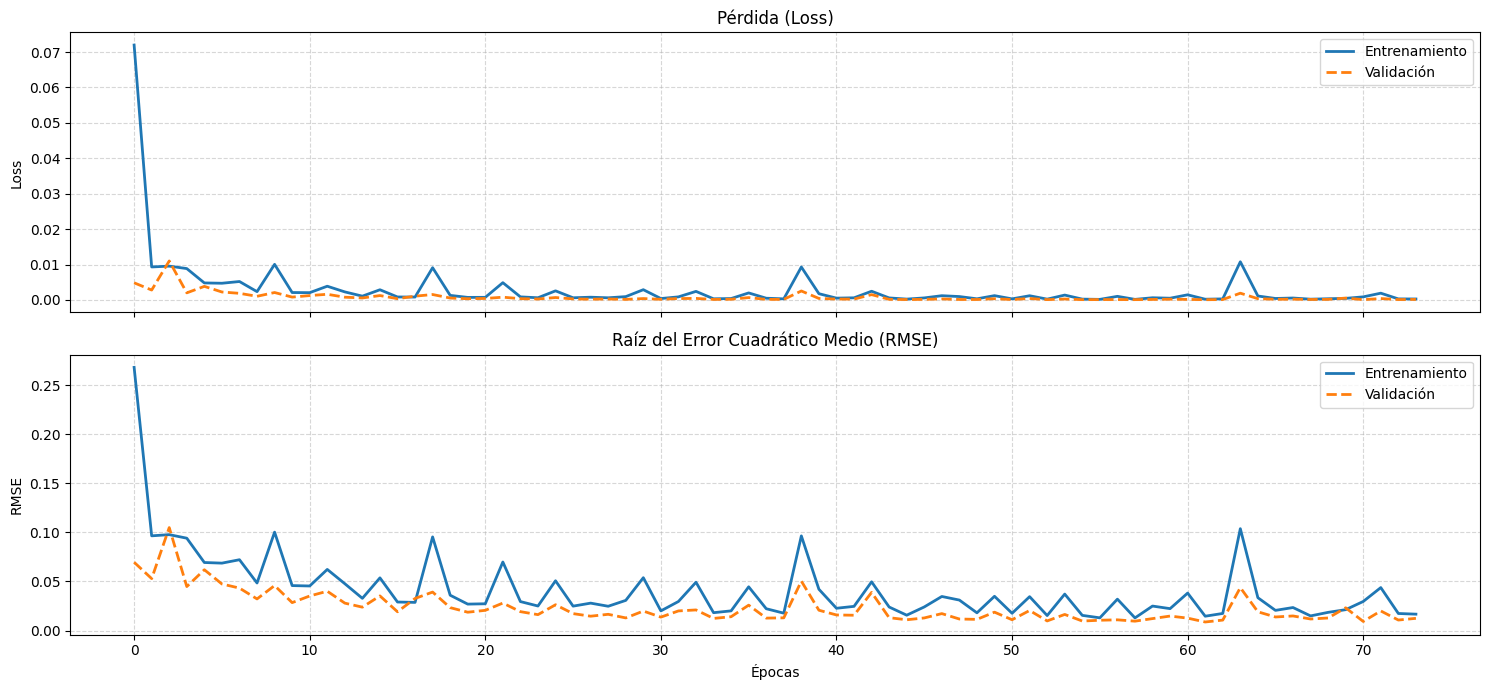

In [15]:
def plot_training_metrics(history):
    fig, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
    
    # ---- LOSS ----
    ax = axes[0]
    if 'loss' in history.history:
        ax.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
    if 'val_loss' in history.history:
        ax.plot(history.history['val_loss'], label='Validación', linewidth=2, linestyle='--')
    ax.set_title('Pérdida (Loss)')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # ---- RMSE ----
    ax = axes[1]
    if 'rmse' in history.history:
        ax.plot(history.history['rmse'], label='Entrenamiento', linewidth=2)
    if 'val_rmse' in history.history:
        ax.plot(history.history['val_rmse'], label='Validación', linewidth=2, linestyle='--')
    ax.set_title('Raíz del Error Cuadrático Medio (RMSE)')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


plot_training_metrics(history)